In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from EvalTools import uncertainty_plot
import gc
import seaborn as sns
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
#optional parameters to only evaluate certain models
optional_dataset = 'jetclass'
optional_tag = 'baseline'
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if optional_dataset in f and optional_tag in f
                      and "Ensemble" not in f and "MCDO" not in f and '.h5' in f and 'slope' not in f and 'mask' not in f and 'nominal' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_best_jetclass_nominal_0.1_v1_baseline.h5
RESULTS_UQPFIN_best_jetclass_nominal_v2_baseline.h5


In [ ]:
for modelname in result_files:
    model_results = {}
    mname = modelname[20:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    labels, preds, oods, probs, uncs, sums = f['labels'][:], f['preds'][:], f['oods'][:], f['probs'][:], f['uncs'][:], f['sums'][:]
    f.close()
    acc = accuracy_score(labels[~oods], preds[~oods])*100
    if "topdata" in mname:
        probs2=probs
    else:
        skiplabels = np.unique(labels[oods])
        probs2=np.delete(probs, skiplabels, 1)

    if probs2.shape[1] == 2:
        probs2 = probs2[:, 1]
    
    # misclassification detection vs anomaly detection
    if "baseline" in mname:
        oods = labels != preds
    
    this_file = os.path.join(saved_model_loc, modelname[8:-3])
    evaluator = ModelEvaluator(this_file)
    nparams = sum(p.numel() for p in evaluator.model.parameters())
    del evaluator
    gc.collect()
    
    # Sensory et al EDL Uncertainty
    auc = roc_auc_score(oods, uncs) * 100
    # print("{} \t\t Params: {}\t Accuracy: {:.2f}% \t AUROC: {:.2f}%".format(mname, nparams, acc, auc))
    
    # D-STD Uncertainty
    sums = torch.from_numpy(sums).reshape(-1,1)
    probs = torch.from_numpy(probs)
    uncs = torch.sqrt(((probs*(1 - probs))/(sums + 1))).sum(1).numpy()
    uncs = torch.sqrt(((probs*(1 - probs))/(sums + 1)).sum(1)).numpy()
    auc_std = roc_auc_score(oods, uncs) * 100

    print("{} \t\t Params: {}\t Accuracy: {:.2f}% \t AUROC: {:.2f}% \t AUROC-STD: {:.2f}%".format(mname, nparams, acc, auc, auc_std))    

jetnet_0.1_skiptop 		 Params: 97008	 Accuracy: 81.61% 	 AUROC: 76.63% 	 AUROC-STD: 77.06%
jetnet_0.1_skiptop_ocmodel 		 Params: 97008	 Accuracy: 81.38% 	 AUROC: 72.09% 	 AUROC-STD: 72.98%
jetnet_0.1_skiptwz 		 Params: 96806	 Accuracy: 83.77% 	 AUROC: 71.14% 	 AUROC-STD: 70.36%
jetnet_0.1_skiptwz_ocmodel 		 Params: 96806	 Accuracy: 83.62% 	 AUROC: 68.51% 	 AUROC-STD: 68.08%
jetnet_0.1_skipwz 		 Params: 96907	 Accuracy: 81.80% 	 AUROC: 68.28% 	 AUROC-STD: 68.20%
jetnet_0.1_skipwz_ocmodel 		 Params: 96907	 Accuracy: 81.66% 	 AUROC: 67.61% 	 AUROC-STD: 67.57%
jetnet_0.5_skiptop 		 Params: 97008	 Accuracy: 81.38% 	 AUROC: 74.90% 	 AUROC-STD: 74.96%
jetnet_0.5_skiptop_ocmodel 		 Params: 97008	 Accuracy: 80.80% 	 AUROC: 74.57% 	 AUROC-STD: 74.55%
jetnet_0.5_skiptwz 		 Params: 96806	 Accuracy: 83.68% 	 AUROC: 69.40% 	 AUROC-STD: 69.48%
jetnet_0.5_skiptwz_ocmodel 		 Params: 96806	 Accuracy: 83.51% 	 AUROC: 69.38% 	 AUROC-STD: 69.34%
jetnet_0.5_skipwz 		 Params: 96907	 Accuracy: 81.51% 	 AUROC: 

jetclass_nominal_0.1_v1_baseline


/tmp/ipykernel_3259306/1175381878.py:304: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


jetclass_nominal_v2_baseline


/tmp/ipykernel_3259306/1175381878.py:304: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


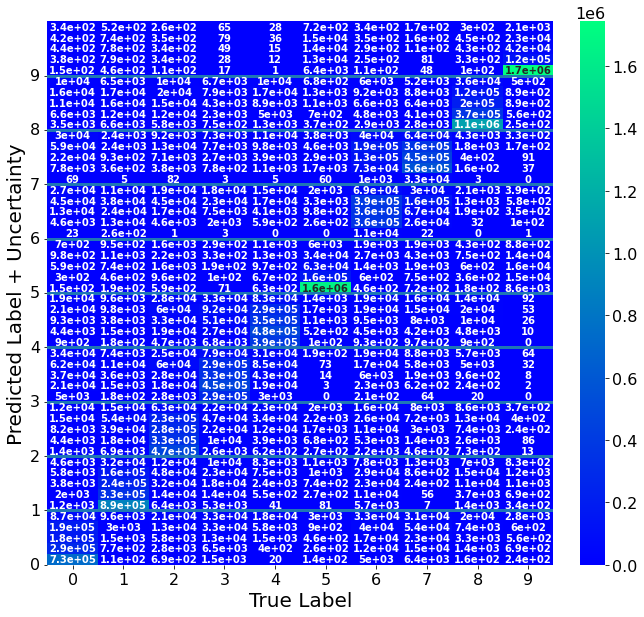

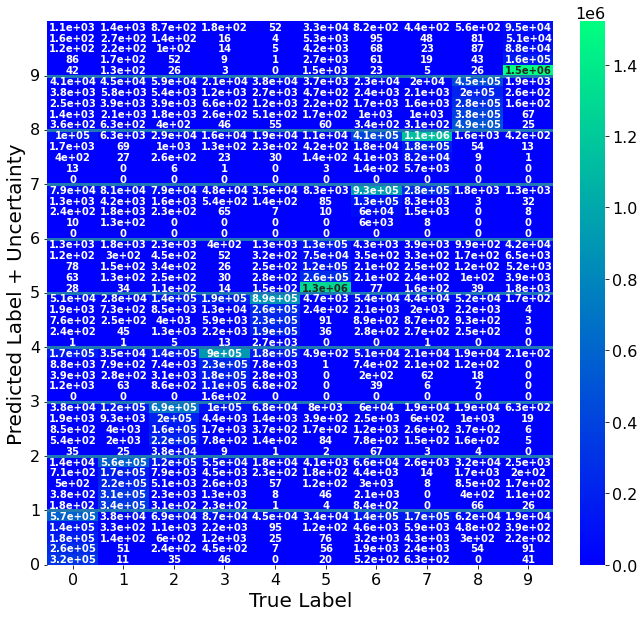

In [31]:
for modelname in result_files:
    key = modelname[20:-3] 
    print(key)
    
    if "jetnet" in key:
        l_max = 5
        fsize=18
        groups = ['QCD', 'QCD', 'Top', 'Bosons', 'Bosons']
    elif "jetclass" in key:
        l_max = 10
        fsize=10
        groups = ['QCD', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Bosons', 'Bosons', 'Top', 'Top']
    elif "JNqgmerged" in key:
        l_max = 4
    else:
        l_max = 2
        fsize=24
        groups = ["background", "signal"]
    groups = np.array(groups)
        
    uniq_names, ind = np.unique(groups, return_index=True)
    uniq_names = uniq_names[np.argsort(ind)]
        
        
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")    
    labels, preds, maxprobs, sums, oods, uncs, probs = f['labels'][:], f['preds'][:], \
                                                f['maxprobs'][:], f['sums'][:], \
                                                f['oods'][:], f['uncs'][:], f['probs'][:]
    f.close()
    
    split = key.split('_')
    coeff = "_".join(split[1:-1])
    for use_std in [False, True]:
        high_unc = 0.8
        if use_std:
            sums = torch.from_numpy(sums).reshape(-1,1)
            probs = torch.from_numpy(probs)
            uncs = torch.sqrt(((probs*(1 - probs))/(sums + 1))).sum(1).numpy()
            coeff += "_std"
            high_unc = 0.5
        
        savefolder = "figures/{}/{}/{}/".format(split[0], split[-1], coeff)
        os.makedirs(savefolder, exist_ok=True)
        
        if 'baseline' in key:
            f1 = 'correct'
            f2 = 'incorrect'
            oods = labels != preds
        else:
            f1 = 'id'
            f2 = 'ood'
        
        
        # for scale in ['', '_log']:
        #     plt.figure(figsize=(10,10))
        #     ax = plt.gca()
        #     ax.hist(uncs[tp], label='TP', bins=np.arange(0.,1.01,0.04), alpha = 0.5, histtype = 'step', linewidth = 5)
        #     ax.hist(uncs[fp], label='FP', bins=np.arange(0.,1.01,0.04), alpha = 0.5, histtype = 'step', linewidth = 5)
        #     ax.hist(uncs[fn], label='FN', bins=np.arange(0.,1.01,0.04), alpha = 0.5, histtype = 'step', linewidth = 5)
        #     ax.hist(uncs[tn], label='TN', bins=np.arange(0.,1.01,0.04), alpha = 0.5, histtype = 'step', linewidth = 5)
        #     ax.set_xlabel('Uncertainty', fontsize=30)
        #     ax.set_ylabel("Number of Events", fontsize = 24)
        #     ax.tick_params(axis='both', which='major', labelsize=24)
        #     if 'jetnet' in key or 'jetclass' in key:
        #         ax.legend(fontsize = 22, loc='upper left')
        #     else:
        #         ax.legend(fontsize = 22)
        #     ax.yaxis.get_offset_text().set_fontsize(24)
        #     plt.tight_layout()
        #     if 'log' in scale:
        #         ax.set_ylabel("Log10(Number of Events)", fontsize = 24)
        #         ax.set_yscale('log')
        #         ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (np.log10(ax.get_ylim()[1]) - np.log10(ax.get_ylim()[0])))
        #     else:
        #         ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
        #     plt.savefig("{}/tp_fp_fn_tn_unc{}.pdf".format(savefolder, scale), dpi = 150)
        mult_label = "Unc"
        if "_0_" in key:
            if "topdata" in key:
                multiple = 300
                if use_std:
                    multiple = 30
            elif "jetnet" in key:
                if "skiptop" in key:
                    multiple = 5
                elif "skiptwz" in key:
                    multiple = 25
                else:
                    multiple = 5*2.5
                    if "skipwz" in key and not use_std:
                        multiple *= 4
            elif "jetclass" in key:
                if "baseline" in key:
                    multiple = 15
                elif "skipwz" in key:
                    multiple = 5*2.5
                else:
                    multiple = 25
            uncs = uncs * multiple
            mult_label = str(multiple) + r' $\times$ Unc'
        
#         for types in ['total', 'separate', 'total_log', 'separate_log']:
#             # Uncertainty distribution
#             plt.figure(figsize=(10,10))
#             ax = plt.gca()
                
#             if 'total' in types:
#                 ax.hist(uncs, bins=np.arange(0.,1.01,0.04), alpha = 0.7, color='blue', weights = (1./len(uncs)) * np.ones_like(uncs))
#             else:
#                 ax.hist(uncs[~oods], bins=np.arange(0.,1.01,0.04), label=f1, alpha = 0.5, histtype = 'step', linewidth = 5, weights = (1./len(uncs[~oods])) * np.ones_like(uncs[~oods]))
#                 ax.hist(uncs[oods], bins=np.arange(0.,1.01,0.04), label=f2, alpha = 0.5, histtype = 'step', linewidth = 5, weights = (1./len(uncs[oods])) * np.ones_like(uncs[oods]))
#                 ax.legend(fontsize = 22)
#             # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
#             ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax.set_ylabel("Fractional Number of Events", fontsize = 24)
#             if 'log' in types:
#                 ax.set_ylabel("Log10(Fractional Number of Events)", fontsize = 24)
#                 ax.set_yscale('log')
#             ax.tick_params(axis='both', which='major', labelsize=24)
#             ax.yaxis.get_offset_text().set_fontsize(24)
#             plt.tight_layout()
#             plt.savefig("{}/unc_normal_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')
            
            
#         for types in ['total', 'separate', 'total_log', 'separate_log']:
#             # Uncertainty distribution
#             plt.figure(figsize=(10,10))
#             ax = plt.gca()
                
#             if 'total' in types:
#                 ax.hist(uncs, bins=np.arange(0.,1.01,0.04), alpha = 0.7, color='blue', weights = (1./len(uncs)) * np.ones_like(uncs))
#             else:
#                 ax.hist(uncs[~oods], bins=np.arange(0.,1.01,0.04), label=f1, alpha = 0.5, histtype = 'step', linewidth = 5)
#                 ax.hist(uncs[oods], bins=np.arange(0.,1.01,0.04), label=f2, alpha = 0.5, histtype = 'step', linewidth = 5)
#                 ax.legend(fontsize = 22)
#             # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
#             ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax.set_ylabel("Number of Events", fontsize = 24)
#             if 'log' in types:
#                 ax.set_ylabel("Log10(Number of Events)", fontsize = 24)
#                 ax.set_yscale('log')
#             ax.tick_params(axis='both', which='major', labelsize=24)
#             ax.yaxis.get_offset_text().set_fontsize(24)
#             plt.tight_layout()
#             plt.savefig("{}/unc_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')
            
#         for types in ['normal', 'log']:
#             # Uncertainty distribution
#             plt.figure(figsize=(10,10))
#             ax = plt.gca()
            
#             for i in range(len(uniq_names)):
#                 indices = np.in1d(labels, np.where(groups == uniq_names[i])[0])
#                 if np.any(indices & oods) and "skip" in key:
#                     lstyle = '--'
#                     lbel = f"{uniq_names[i]} (OOD)"
#                 else:
#                     lstyle = '-'
#                     lbel = uniq_names[i]
#                 ax.hist(uncs[(labels == preds) & indices], bins=np.arange(0.,1.01,0.04), label=lbel, alpha = 0.5, histtype = 'step', linewidth = 5, linestyle = lstyle, weights = (1./len(uncs[(labels == preds) & indices])) * np.ones_like(uncs[(labels == preds) & indices]))
#             ax.legend(fontsize = 22)
#             # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
#             ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax.set_ylabel("Fractional Number of Events", fontsize = 24)
#             if 'log' in types:
#                 ax.set_ylabel("Log10(Fractional Number of Events)", fontsize = 24)
#                 ax.set_yscale('log')
#             ax.tick_params(axis='both', which='major', labelsize=24)
#             ax.yaxis.get_offset_text().set_fontsize(24)
#             plt.tight_layout()
#             plt.savefig("{}/unc_correct_class_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')
            
#         for types in ['normal', 'log']:
#             # Uncertainty distribution
#             plt.figure(figsize=(10,10))
#             ax = plt.gca()
            
#             for i in range(len(uniq_names)):
#                 indices = np.in1d(labels, np.where(groups == uniq_names[i])[0])
#                 if np.any(indices & oods) and "skip" in key:
#                     lstyle = '--'
#                     lbel = f"{uniq_names[i]} (OOD)"
#                 else:
#                     lstyle = '-'
#                     lbel = uniq_names[i]
#                 ax.hist(uncs[indices], bins=np.arange(0.,1.01,0.04), label=lbel, alpha = 0.5, histtype = 'step', linewidth = 5, linestyle = lstyle, weights = (1./len(uncs[indices])) * np.ones_like(uncs[indices]))
#             ax.legend(fontsize = 22)
#             # ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
#             ax.set_xlabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax.set_ylabel("Fractional Number of Events", fontsize = 24)
#             if 'log' in types:
#                 ax.set_ylabel("Log10(Fractional Number of Events)", fontsize = 24)
#                 ax.set_yscale('log')
#             ax.tick_params(axis='both', which='major', labelsize=24)
#             ax.yaxis.get_offset_text().set_fontsize(24)
#             plt.tight_layout()
#             plt.savefig("{}/unc_class_{}.pdf".format(savefolder, types), dpi = 150, bbox_inches='tight')
            
        
        filetypes = ['total', f1, f2]
        indices = [oods | ~oods, ~oods, oods]
        
#         for filetype, idx in zip(filetypes, indices):
#             # Max Prob. vs Uncertainty distribution
#             hist, _, _ = np.histogram2d(maxprobs[idx], uncs[idx], bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
            
#             fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
#             heatmap = sns.heatmap(hist.T, annot=False, cmap='winter', ax=ax[0], cbar_ax=ax[1])
#             ax[0].invert_yaxis()
#             ax[0].set_xlabel("Max. Prob.", fontsize=30)
#             ax[0].set_ylabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax[0].set_yticks(np.arange(0, 26, 5))
#             ax[0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], rotation=0)
#             ax[0].set_xticks(np.arange(0, 26, 5))
#             ax[0].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
#             ax[0].tick_params(axis='both', which='major', labelsize=20)
#             cbar = heatmap.collections[0].colorbar
#             cbar.ax.tick_params(labelsize=24)
#             cbar.ax.yaxis.get_offset_text().set_fontsize(24)
#             if 'topdata' in key or 'jetnet' in key:
#                 tick_values = cbar.get_ticks()
#                 cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
#             plt.tight_layout()
#             plt.savefig("{}/unc_prob_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')
        
#         for filetype, idx in zip(filetypes, indices):
#             # Max Prob. vs Uncertainty distribution (Log Scale)
#             hist, _, _ = np.histogram2d(maxprobs[idx], uncs[idx], bins = [np.arange(0.,1.01,0.04), np.arange(0.,1.01,0.04)])
            
#             fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
#             heatmap = sns.heatmap(hist.T+1, annot=False, cmap='winter', ax=ax[0], cbar_ax=ax[1], norm=LogNorm())
#             ax[0].invert_yaxis()
#             ax[0].set_xlabel("Max. Prob.", fontsize=30)
#             ax[0].set_ylabel("Uncertainty".replace("Unc", mult_label), fontsize=30)
#             ax[0].set_yticks(np.arange(0, 26, 5))
#             ax[0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], rotation=0)
#             ax[0].set_xticks(np.arange(0, 26, 5))
#             ax[0].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
#             ax[0].tick_params(axis='both', which='major', labelsize=20)
#             cbar = heatmap.collections[0].colorbar
#             cbar.ax.tick_params(labelsize=24)
#             plt.tight_layout()
#             plt.savefig("{}/unc_prob_{}_log.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')
   
#         for filetype, idx in zip(filetypes, indices):
#             # Labels vs Preds
#             arr = np.zeros((l_max,l_max))
#             for i in range(l_max):
#                 for j in range(l_max):
#                     arr[j, i] = np.sum((labels[idx] == i) & (preds[idx] == j))
            
#             fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
#             heatmap = sns.heatmap(arr, annot=True, cmap='winter', annot_kws={"size": fsize, "weight": "bold"}, ax=ax[0], cbar_ax=ax[1])
#             ax[0].invert_yaxis()
#             ax[0].set_xlabel("Labels", fontsize=30)
#             ax[0].set_ylabel("Preds", fontsize=30)
#             ax[0].tick_params(axis='both', which='major', labelsize=24)
#             ax[0].tick_params(axis='y', labelrotation=0)
#             cbar = heatmap.collections[0].colorbar
#             cbar.ax.tick_params(labelsize=24)
#             cbar.ax.yaxis.get_offset_text().set_fontsize(24)
#             if 'topdata' in key or 'jetnet' in key:
#                 tick_values = cbar.get_ticks()
#                 cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
#             plt.tight_layout()
#             plt.savefig("{}/labels_preds_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')
            
        for filetype, idx in zip(filetypes, indices):
            # Labels vs Preds + Uncertainty
            uncertainty_bins = np.zeros((5*l_max, l_max))  # 5 bins for uncertainty
            for i in range(l_max):
                for j in range(l_max):
                    filtered_indices = (labels[idx] == i) & (preds[idx] == j)
                    if np.sum(filtered_indices) > 0:
                        # Create histogram for uncertainty values in 5 bins
                        hist, _ = np.histogram(uncs[idx][filtered_indices], bins=5, range=(0, 1))
                        for k in range(5):
                            uncertainty_bins[5*j+k, i] = hist[k]
                            
            fig, ax  = plt.subplots(1, 2, figsize=(10,10), gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1})
            heatmap = sns.heatmap(uncertainty_bins, annot=True, cmap='winter', annot_kws={"size": fsize, "weight": "bold"}, ax=ax[0], cbar_ax=ax[1])
            ax[0].invert_yaxis()
            uacm_axsize = 30
            if "jetclass" in key:
                uacm_axsize = 20
            ax[0].set_xlabel("True Label", fontsize=uacm_axsize)
            ax[0].set_ylabel("Predicted Label + Uncertainty".replace("Unc", mult_label), fontsize=uacm_axsize)
            for jj in np.arange(5,5*l_max, 5):
                ax[0].axhline(jj, linewidth=3)
            ax[0].set_yticks(np.arange(0, 5*l_max, 5))
            ax[0].set_yticklabels(np.arange(0, l_max), rotation=0)
            uacm_fsize = 24
            if "jetclass" in key:
                uacm_fsize = 16
            ax[0].tick_params(axis='both', which='major', labelsize=uacm_fsize)
            cbar = heatmap.collections[0].colorbar
            cbar.ax.tick_params(labelsize=uacm_fsize)
            cbar.ax.yaxis.get_offset_text().set_fontsize(uacm_fsize)
            if 'topdata' in key or 'jetnet' in key:
                tick_values = cbar.get_ticks()
                cbar.set_ticklabels([f'{int(tick / 1000)}k' for tick in tick_values])
            plt.tight_layout()
            plt.savefig("{}/labels_preds_unc_{}.pdf".format(savefolder, filetype), dpi = 150, bbox_inches='tight')
            break
            
        break
            
            
            
        
            

In [9]:
key

'topdata_nominal_0.1_baseline'

In [14]:
indices = np.in1d(labels, np.where(groups == uniq_names[i])[0])

In [20]:
groups == 'signal'

False

(array([3.431e+03, 4.962e+03, 3.804e+03, 4.019e+03, 4.323e+03, 4.102e+03,
        5.036e+03, 5.182e+03, 5.860e+02, 1.000e+00]),
 array([0.03255124, 0.11094578, 0.18934032, 0.26773486, 0.3461294 ,
        0.42452392, 0.5029185 , 0.581313  , 0.65970755, 0.7381021 ,
        0.8164966 ], dtype=float32),
 <BarContainer object of 10 artists>)

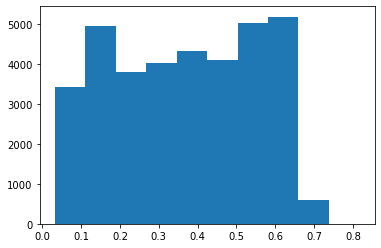

In [36]:
plt.hist(uncs[labels == preds & indices])

In [9]:
for i in range(10):
    for j in range(10):
        idx = i*10+j
        f = b[idx] - a[idx]
        if (abs(f) > 10000):
            print(f)
            print(i, j)

21251
0 3
-12941
0 7
23356
1 0
-42698
1 1
12172
1 3
28239
2 0
23619
2 1
-70469
2 2
15818
2 3
19450
4 0
-13870
4 4
29140
5 0
-30764
5 5
47213
6 0
-57704
6 6
50300
7 0
-51461
7 7
30310
8 0
-11001
8 2
-20235
8 8
15151
9 0
-17221
9 9


In [12]:
for i in range(10):
    print(b[i] - a[i])

3001
-42698
-70469
-4228
-13870
-30764
-57704
-51461
-20235
-17221


In [56]:
np.percentile(uncs/5, 95)*1400

0.9831675299210465

(array([1.75998e+05, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([2.7877168e-04, 1.0025089e-01, 2.0022301e-01, 3.0019513e-01,
        4.0016726e-01, 5.0013942e-01, 6.0011148e-01, 7.0008361e-01,
        8.0005574e-01, 9.0002787e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

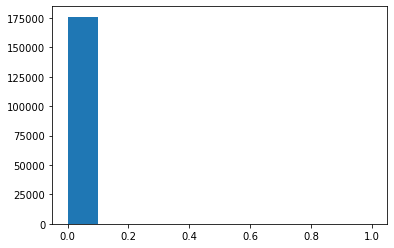

In [6]:
plt.hist(uncs)

In [33]:
plt.hist(uncs[labels == 2 & labels == preds])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
np.in1d(labels